# 数据处理代码测试

In [13]:
import logging

import numpy as np

from config_loader import load_data_config
from data_preprocess import load_data
import pandas as pd

# 假设您已经定义了 create_dataloader 和 load_data 函数
try:
    datasets = ['NASA', 'CALCE']
    for dataset in datasets:
        data_config, val_bat, test_bat, bats, lookback_len, pred_len, rated_capacity, fail_soh, batch_size = load_data_config(dataset)
        data_df = pd.read_csv('data/' + dataset + '.csv', encoding='utf-8')
        train_loader, val_loader, test_loader = load_data(data_df, val_bat, test_bat, lookback_len, pred_len, batch_size)
        print("数据加载器创建成功！")
        # 尝试从 DataLoader 中获取一些数据来看是否正确
        for data in train_loader:
            print("训练数据示例：", data)
            break
        for data in val_loader:
            print("验证数据示例：", data)
            break
        for data in test_loader:
            print("测试数据示例：", data)
            break
except Exception as e:
    print("在数据处理过程中发生错误：", str(e))

数据加载器创建成功！
训练数据示例： [tensor([[0.8438, 0.8415, 0.8390, 0.8366, 0.8337, 0.8311, 0.8287, 0.8263, 0.8236,
         0.8182, 0.8181, 0.8206, 0.8158, 0.8106, 0.8082, 0.8079],
        [0.7533, 0.7507, 0.7482, 0.7667, 0.7619, 0.7506, 0.7462, 0.7417, 0.7404,
         0.7368, 0.7340, 0.7290, 0.7239, 0.7264, 0.7213, 0.7196],
        [0.7975, 0.7952, 0.7927, 0.7900, 0.7876, 0.7849, 0.7851, 0.7826, 0.7798,
         0.7825, 0.7875, 0.7826, 0.7799, 0.7749, 0.7719, 0.7725],
        [0.9058, 0.9030, 0.9066, 0.9031, 0.8979, 0.8929, 0.8902, 0.9075, 0.9079,
         0.9001, 0.8952, 0.8902, 0.8877, 0.8851, 0.8800, 0.8748],
        [0.7620, 0.7593, 0.7568, 0.7568, 0.7570, 0.7670, 0.7696, 0.7618, 0.7568,
         0.7539, 0.7516, 0.7489, 0.7464, 0.7462, 0.7437, 0.7413],
        [0.9314, 0.9260, 0.9235, 0.9184, 0.9186, 0.9158, 0.9106, 0.9083, 0.9057,
         0.9058, 0.9030, 0.9066, 0.9031, 0.8979, 0.8929, 0.8902],
        [0.9300, 0.9296, 0.9241, 0.9246, 0.9417, 0.9314, 0.9260, 0.9235, 0.9184,
         0.9186, 

# 训练、验证、测试 - 多组实验

In [1]:
import torch
import torch.nn as nn
from data_preprocess import load_data
from train_util import get_model, set_seed, get_optimizer
from config_loader import load_common_config, load_data_config
import os
import pandas as pd
import time
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# 公共参数
models_config, seeds, device = load_common_config()

alpha = 1  # loss_soh 的比重
# datasets = ['NASA', 'CALCE']
datasets = ['CALCE']
# model_names = ['model_v1', 'model_v2', 'model_v2_1', 'model_v2_2', 'model_v3', 'model_v4', 'model_v4_1', 'model_v5']
model_names = ['model_v6']
save_model = False
seeds = seeds[1:2]
patience = 20  # 耐心值，即连续多少个epoch无改进时停止训练

for i in range(len(seeds)):
    set_seed(seeds[i])
    for dataset in datasets:
        # 加载数据
        data_config, val_bat, test_bat, lookback_len, pred_len, rated_capacity, batch_size = load_data_config(dataset)
        data_df = pd.read_csv('data/' + dataset + '.csv', encoding='utf-8')    
        train_loader, val_loader, test_loader = load_data(data_df, val_bat, test_bat, lookback_len, pred_len, batch_size)

        for model_name in model_names:
            model_save_path = f"saved_models/{dataset}/{model_name}_s-{i+1}.pth"
            # 模型相关参数
            model_config = models_config[model_name]
            _, lr, optim_name, max_epochs, det_alpha, rmsprop_alpha = (
                model_config['batch_size'],
                model_config['lr'],
                model_config['optimizer'],
                model_config['max_epochs'],
                model_config.get('det_alpha', None),
                model_config.get('rmsprop_alpha', None)
            )
            model_config['lookback_len'] = lookback_len
            model_config['pred_len'] = pred_len
            
            model = get_model(model_config, device, lookback_len)
            # lr = 3e-4
            optimizer = get_optimizer(optim_name, model, lr, rmsprop_alpha)
            criterion_soh, criterion_rul = nn.MSELoss(), nn.MSELoss()
            
            # 训练
            train_losses = []
            val_losses = []
            test_losses = []
            best_val_loss = np.inf
            patience_counter = 0  # 耐心计数器
            for epoch in range(max_epochs):
                model.train()
                train_loss = 0.0
                for features, soh, rul in train_loader:
                    """
                    features: (batch_size, lookback_len, 1)
                    soh: (batch_size, pred_len)
                    rul: (batch_size,)
                    """
                    features, soh, rul = features.to(device), soh.to(device), rul.to(device)
                    optimizer.zero_grad()
                    soh_pred, rul_pred = model(features)
                    loss_soh = criterion_soh(soh_pred, soh)
                    loss_rul = criterion_rul(rul_pred, rul)
                    loss = alpha * loss_soh + loss_rul
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                train_loss /= len(train_loader)
                train_losses.append(train_loss)
                
                # 验证
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for features, soh, rul in val_loader:
                        soh_pred, rul_pred = model(features)
                        loss_soh = criterion_soh(soh_pred, soh)
                        loss_rul = criterion_rul(rul_pred, rul)
                        loss = alpha * loss_soh + loss_rul
                        val_loss += loss.item()
                    val_loss /= len(val_loader)
                val_losses.append(val_loss)
                        
                # 测试
                test_loss = 0.0
                test_soh_loss = 0.0
                test_rul_loss = 0.0
                with torch.no_grad():
                    for features, soh, rul in test_loader:
                        soh_pred, rul_pred = model(features)
                        loss_soh = criterion_soh(soh_pred, soh)
                        loss_rul = criterion_rul(rul_pred, rul)
                        loss = alpha * loss_soh + loss_rul
                        test_loss += loss.item()
                        test_soh_loss += loss_soh.item()
                        test_rul_loss += loss_rul.item()
                    test_loss /= len(test_loader)
                    test_soh_loss /= len(test_loader)
                    test_rul_loss /= len(test_loader)
                test_losses.append(test_loss)
                test_soh_rmse = torch.sqrt(torch.tensor(test_soh_loss))
                test_rul_rmse = torch.sqrt(torch.tensor(test_rul_loss))
                
                print(f"Seed: {i + 1}, Dataset: {dataset}, Model: {model_name}, Epoch: {epoch + 1:03d} | "
                      f"Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Test Loss: {test_loss:.5f} | "
                      f"Test SOH RMSE: {test_soh_rmse:.4f}, Test RUL RMSE: {test_rul_rmse:.4f}")
                
                # TODO 早停
                # TODO 结果保存为csv
                # 保存模型
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    if save_model:
                        torch.save(model.state_dict(), model_save_path)
                    print("New best model saved ...")
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping triggered at Epoch", epoch + 1)
                        break


Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 001 | Train Loss: 0.24821, Val Loss: 0.09578, Test Loss: 0.05638 | Test SOH RMSE: 0.0797, Test RUL RMSE: 0.2237
New best model saved ...
Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 002 | Train Loss: 0.03702, Val Loss: 0.09561, Test Loss: 0.03942 | Test SOH RMSE: 0.0522, Test RUL RMSE: 0.1915
New best model saved ...
Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 003 | Train Loss: 0.01862, Val Loss: 0.09826, Test Loss: 0.01709 | Test SOH RMSE: 0.0436, Test RUL RMSE: 0.1232
Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 004 | Train Loss: 0.01477, Val Loss: 0.09063, Test Loss: 0.01171 | Test SOH RMSE: 0.0422, Test RUL RMSE: 0.0996
New best model saved ...
Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 005 | Train Loss: 0.01100, Val Loss: 0.08934, Test Loss: 0.01309 | Test SOH RMSE: 0.0412, Test RUL RMSE: 0.1067
New best model saved ...
Seed: 1, Dataset: CALCE, Model: model_v6, Epoch: 006 | Train Loss: 0.01047, Val Loss: 0.09011, 

KeyboardInterrupt: 

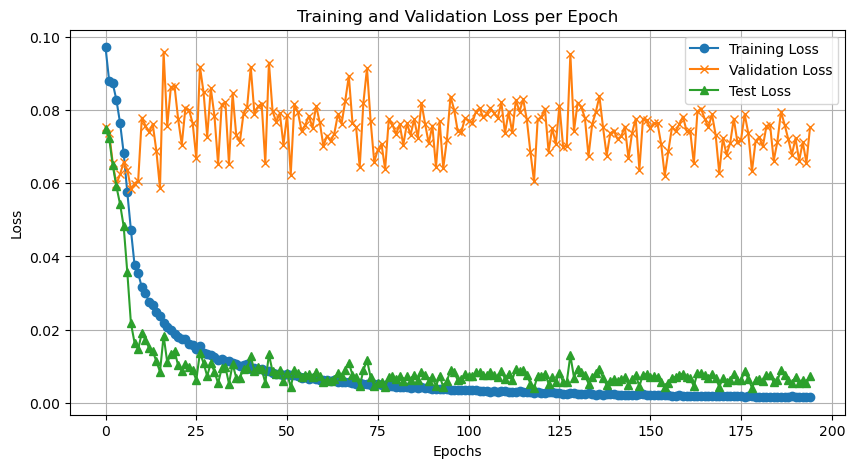

In [14]:
# 绘制图形
plt.figure(figsize=(10, 5))
start_epoch = 5
plt.plot(train_losses[start_epoch:], label='Training Loss', marker='o')
plt.plot(val_losses[start_epoch:], label='Validation Loss', marker='x')
plt.plot(test_losses[start_epoch:], label='Test Loss', marker='^')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

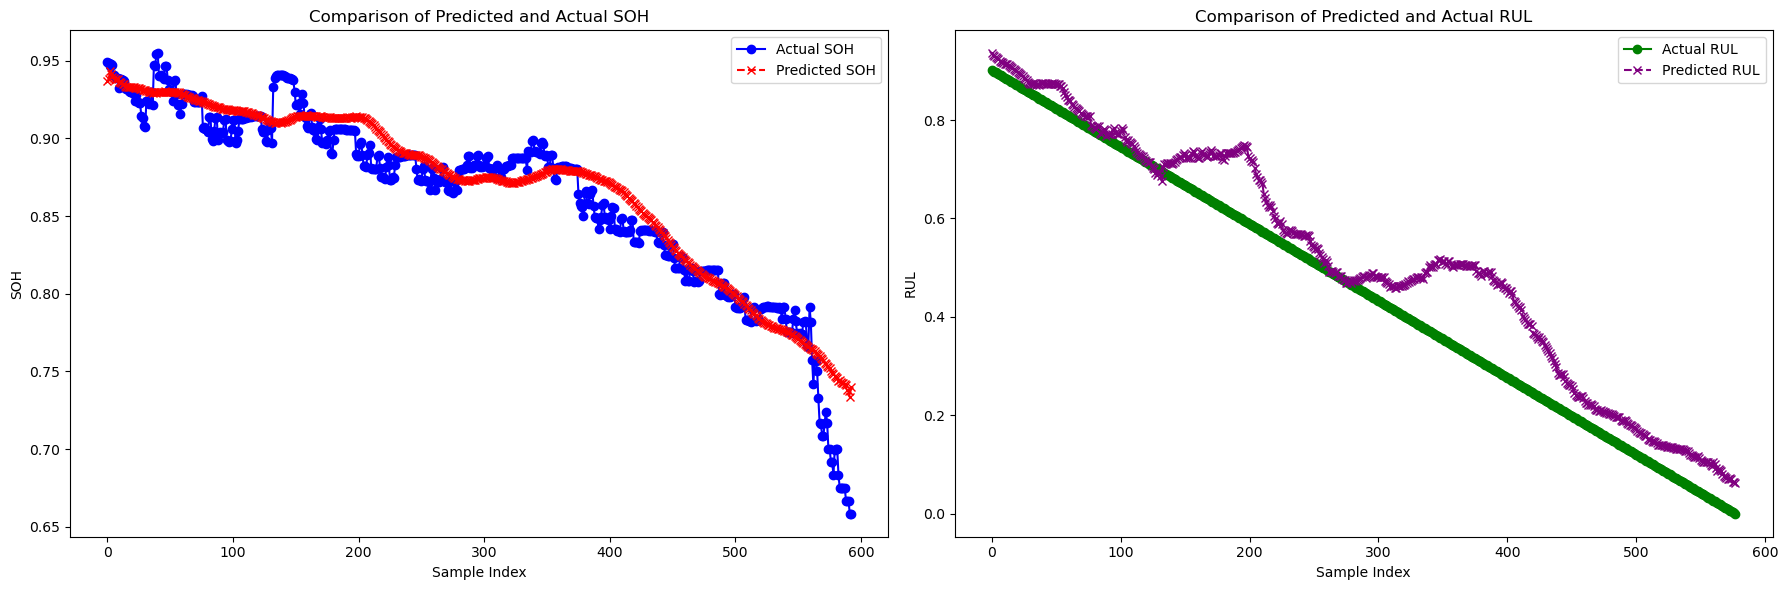

In [15]:
predictions_by_time = defaultdict(list)
true_by_time = defaultdict(list)
rul_preds = []
rul_true = []

with torch.no_grad():
    time_step = 0  # 初始化时间步
    for features, soh, rul in test_loader:
        soh_pred, rul_pred = model(features)
        
        # 转换为numpy数组以方便处理
        soh_pred = np.array(soh_pred)
        soh = np.array(soh)
        # 更新predictions_by_time
        for i in range(soh_pred.shape[0]):  # 遍历batch中的每个样本
            current_base_time = time_step + i
            for j in range(pred_len):  # 遍历每个样本的所有预测步
                predictions_by_time[current_base_time + j].append(soh_pred[i, j])
                true_by_time[current_base_time + j].append(soh[i, j])
        time_step += soh_pred.shape[0]  # 更新时间步
        
        rul_preds.extend(rul_pred.flatten().tolist())
        rul_true.extend(rul.tolist())

# 计算平均预测
average_predictions = {t: np.mean(vals) for t, vals in predictions_by_time.items()}
average_true = {t: np.mean(vals) for t, vals in true_by_time.items()}
soh_preds = list(average_predictions.values())
soh_true = list(average_true.values())

# 绘制SOH的预测与实际值对比图
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)  # 1行2列的第1个
plt.plot(soh_true, label='Actual SOH', color='blue', marker='o')
plt.plot(soh_preds, label='Predicted SOH', color='red', linestyle='--', marker='x')
plt.title('Comparison of Predicted and Actual SOH')
plt.xlabel('Sample Index')
plt.ylabel('SOH')
plt.legend()

# 绘制RUL的预测与实际值对比图
plt.subplot(1, 2, 2)  # 1行2列的第2个
plt.plot(rul_true, label='Actual RUL', color='green', marker='o')
plt.plot(rul_preds, label='Predicted RUL', color='purple', linestyle='--', marker='x')
plt.title('Comparison of Predicted and Actual RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()

plt.tight_layout()
plt.show()

# 交叉验证

## 导入模块

In [62]:
import torch
import torch.nn as nn
from data_preprocess import load_data
from train_util import get_model, set_seed, get_optimizer
from config_loader import load_common_config, load_data_config
import os
import pandas as pd
import time
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math
from models.LSTM import LSTM
from models.GRU import GRU
from models.DeTransformer import DeTransformer
from models.model_v6 import model_v6
import itertools

## 训练函数

In [77]:
def train(model, dataset, val_bat, test_bat, lookback_len, pred_len, alpha, batch_size, lr, max_epochs=5000, device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'), criterion=nn.MSELoss(), feature_num=None, patience=50, save_model=False, save_model_path=None, det_alpha=0.1, dropout=0):
    data_df = pd.read_csv('data/' + dataset + '.csv', encoding='utf-8')
    if isinstance(model, LSTM):
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader, val_loader, test_loader = load_data(data_df, val_bat, test_bat, lookback_len, pred_len, batch_size)
    # 训练
    train_losses, val_losses, test_losses = [], [], []
    best_metric = np.inf
    patience_counter = 0  # 耐心计数器
    start_time = time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0.0
        for features, soh, rul in train_loader:
            """
            features: (batch_size, lookback_len, 1)
            soh: (batch_size, pred_len)
            rul: (batch_size,)
            """
            features, soh, rul = features.to(device), soh.to(device), rul.to(device)
            optimizer.zero_grad()
            if not isinstance(model, DeTransformer):
                soh_pred, rul_pred = model(features)
                loss_soh = criterion(soh_pred, soh)
                loss_rul = criterion(rul_pred, rul)
                loss = alpha * loss_soh + loss_rul
            else:
                features = features.transpose(1, 2).repeat(1, feature_num, 1)
                soh_pred, rul_pred, decodes = model(features)
                loss_soh = criterion(soh_pred, soh)
                loss_rul = criterion(rul_pred, rul)
                loss = alpha * loss_soh + loss_rul + det_alpha * criterion(features, decodes)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss, val_soh_loss, val_rul_loss = 0.0, 0.0, 0.0
        with torch.no_grad():
            for features, soh, rul in val_loader:
                features, soh, rul = features.to(device), soh.to(device), rul.to(device)
                if not isinstance(model, DeTransformer):
                    soh_pred, rul_pred = model(features)
                    loss_soh = criterion(soh_pred, soh)
                    loss_rul = criterion(rul_pred, rul)
                    loss = alpha * loss_soh + loss_rul
                else:
                    features = features.transpose(1, 2).repeat(1, feature_num, 1)
                    soh_pred, rul_pred, decodes = model(features)
                    loss_soh = criterion(soh_pred, soh)
                    loss_rul = criterion(rul_pred, rul)
                    loss = alpha * loss_soh + loss_rul + det_alpha * criterion(features, decodes)
                val_loss += loss.item()
                val_soh_loss += loss_soh.item()
                val_rul_loss += loss_rul.item()
            val_loss /= len(val_loader)
            val_soh_loss /= len(val_loader)
            val_rul_loss /= len(val_loader)
            val_losses.append(val_loss)
            val_soh_rmse, val_rul_rmse = np.sqrt(val_soh_loss), np.sqrt(val_rul_loss)
            
        print(
            # f"Model: {type(model).__name__}, "
            # f"lr-bs: {lr}-{batch_size}, "
            # f"m: {model_dim}, "
            # f"kdl: {kernel_size}-{depth}-{num_layers} "
            f"ht-hs: {num_heads_t}-{num_heads_s}, "
            # f"alpha: {alpha:.1f}, "
            # f"dropout: {dropout:.2f}, "
            f"Val Bat: {val_bat}, Epoch: {epoch + 1:03d} | "
            f"Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f} | "
            f"SOH RMSE: {val_soh_rmse:.4f}, RUL RMSE: {val_rul_rmse:.4f}"
        )
        
        if val_rul_loss < best_metric:
            best_train_loss, best_val_loss, best_val_soh_rmse, best_val_rul_rmse = train_loss, val_loss, val_soh_rmse, val_rul_rmse
            best_metric = val_rul_loss
            patience_counter = 0
            if save_model:
                torch.save(model.state_dict(), save_model_path)
            print("New best metric saved ...")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered at Epoch", epoch + 1)
                
                # 保存结果
                end_time = time.time()
                duration = end_time - start_time
                # result = {
                #     'model': type(model).__name__,
                #     'val_bat': val_bat,
                #     'train_loss': best_train_loss,
                #     'val_loss': best_val_loss,
                #     'val_soh_rmse': best_val_soh_rmse,
                #     'val_rul_rmse': best_val_rul_rmse,
                #     'epochs': epoch + 1 - patience_counter,
                #     'time_per_epoch': duration / (epoch + 1)
                # }
            
                result = {
                    'lr': lr,
                    'bs': batch_size,
                    'model_dim': model_dim,
                    'ks': kernel_size,
                    'depth': depth,
                    'num_layers': num_layers,
                    'num_heads': num_heads_t,
                    'num_heads_s': num_heads_s,
                    'alpha': alpha,
                    'dropout': dropout,
                    'val_bat': val_bat,
                    'train_loss': best_train_loss,
                    'val_loss': best_val_loss,
                    'val_soh_rmse': best_val_soh_rmse,
                    'val_rul_rmse': best_val_rul_rmse,
                    'epochs': epoch + 1 - patience_counter,
                    'time_per_epoch': duration / (epoch + 1)
                }
                
                # csv文件不存在时，先创建，并定义表头
                if not os.path.exists(result_path):
                    columns = ['lr', 'bs', 'model_dim', 'ks', 'depth', 'num_layers', 'num_heads', 'num_heads_s', 'alpha', 'dropout', 'val_bat','train_loss', 'val_loss', 'val_soh_rmse', 'val_rul_rmse', 'epochs', 'time_per_epoch']
                    # columns = ['model', 'val_bat', 'train_loss', 'val_loss', 'val_soh_rmse', 'val_rul_rmse', 'epochs', 'time_per_epoch']
                    df = pd.DataFrame(columns=columns)
                    df.to_csv(result_path, index=False)
                pd.DataFrame([result]).to_csv(result_path, mode='a', header=False, index=False)
                break
    # return train_losses, val_losses, test_losses


## 配置训练参数

In [80]:
# 统一配置
seeds = [42, 123, 2024, 7, 99]
patience = 50
save_model = False
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
det_alpha = 0.1

# 数据集
dataset = 'NASA'
bats = ['B0005', 'B0006', 'B0007', 'B0018']
# dataset = 'CALCE'
# bats = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
lookback_len = 16
pred_len = 4

result_path = 'param_search_res/all_res_new/nasa_ht_hs.csv'
# lr_list = np.arange(1e-4, 11e-4, 1e-4)
# bs_list = [4, 8, 16, 32, 64]
# m_list = [4, 8, 16, 32, 64]
# ks_list = [2, 3, 5, 7]
# d_list = [2, 3, 4]
# l_list = [1, 2, 3, 4]
ht_list = [1, 2, 4]
hs_list = [1, 2, 4]
# a_list = np.arange(0, 1.1, 0.1)
# dp_list = np.arange(0, 0.11, 0.01)

# model_v6
lr = 9e-4
batch_size = 4
model_dim = 16
kernel_size = 2
depth = 2
num_layers = 2
num_heads_t = 1
num_heads_s = 1
alpha = 0.1
# alpha = 0.64
dropout = 0

# lstm
# lr = 1e-3
# batch_size = 32
# hidden_sizes = [50,100]
# dropout = 0.8
# alpha = 0.1

# gru
# lr = 1e-3
# batch_size = 32
# hidden_size = 64
# num_layers = 4
# dropout = 0.5
# alpha = 0.1

# det
# lr = 1e-3
# batch_size = 32
# hidden_dim = 16
# feature_num = 16
# num_layers = 3
# nhead = 1
# dropout = 0.001
# det_alpha = 0.1
# alpha = 0.1

## 训练

In [81]:
# for lr in lr_list:
#     for batch_size in bs_list:
#         for model_dim in m_list:
# for num_heads_t in num_heads_t_list:
#     for num_heads_s in num_heads_s_list:
# alpha_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# alpha_list = [0.2, 0.1]
# patience = 20
# for alpha in alpha_list:
# for dp in dp_list:
# for kernel_size, depth, num_layers in itertools.product(ks_list, d_list, l_list):
for num_heads_t, num_heads_s in itertools.product(ht_list, hs_list):
    for bat in bats:
        set_seed(seeds[0])
        # 初始化模型
        # model = LSTM(input_size=1, hidden_sizes=hidden_sizes, pred_len=pred_len, dropout=dropout)
        # model = GRU(input_size=1, hidden_size=hidden_size, pred_len=pred_len, num_layers=num_layers, dropout=dropout)
        # model = DeTransformer(feature_size=lookback_len, pred_len=pred_len, hidden_dim=hidden_dim, feature_num=feature_num, num_layers=num_layers, nhead=nhead, dropout=dropout)
        model = model_v6(input_dim=1, model_dim=model_dim, lookback_len=lookback_len, num_heads=num_heads_t, num_heads_s=num_heads_s, num_layers=num_layers, depth=depth, kernel_size=kernel_size, pred_len=pred_len, dropout=dropout)
    
        train(model=model.to(device), dataset=dataset, val_bat=bat, test_bat=None, lookback_len=lookback_len, pred_len=pred_len, alpha=alpha, batch_size=batch_size, lr=lr, feature_num=16, patience=patience, det_alpha=det_alpha, dropout=dropout)

ht-hs: 1-1, Val Bat: B0005, Epoch: 001 | Train Loss: 0.07708, Val Loss: 0.08673 | SOH RMSE: 0.0781, RUL RMSE: 0.2935
New best metric saved ...
ht-hs: 1-1, Val Bat: B0005, Epoch: 002 | Train Loss: 0.06980, Val Loss: 0.07070 | SOH RMSE: 0.0752, RUL RMSE: 0.2648
New best metric saved ...
ht-hs: 1-1, Val Bat: B0005, Epoch: 003 | Train Loss: 0.06102, Val Loss: 0.02214 | SOH RMSE: 0.1183, RUL RMSE: 0.1440
New best metric saved ...
ht-hs: 1-1, Val Bat: B0005, Epoch: 004 | Train Loss: 0.02180, Val Loss: 0.00963 | SOH RMSE: 0.0370, RUL RMSE: 0.0975
New best metric saved ...
ht-hs: 1-1, Val Bat: B0005, Epoch: 005 | Train Loss: 0.00597, Val Loss: 0.00816 | SOH RMSE: 0.0247, RUL RMSE: 0.0900
New best metric saved ...
ht-hs: 1-1, Val Bat: B0005, Epoch: 006 | Train Loss: 0.00701, Val Loss: 0.00991 | SOH RMSE: 0.0247, RUL RMSE: 0.0993
ht-hs: 1-1, Val Bat: B0005, Epoch: 007 | Train Loss: 0.00637, Val Loss: 0.00743 | SOH RMSE: 0.0203, RUL RMSE: 0.0860
New best metric saved ...
ht-hs: 1-1, Val Bat: B000

# 表格修改

## 添加dropout列

In [ ]:
# df_path = 'param_search_res/all_res/nasa_a.csv'
# df = pd.read_csv(df_path)
# df.insert(loc=9, column='dropout', value=0)
# display(df)
# df.to_csv(df_path, index=False)

## 聚合搜参结果

In [82]:
all_dir = 'param_search_res/all_res_new'
group_dir = 'param_search_res/group_res_new'

params = ['lr', 'bs', 'model_dim', 'ks', 'depth', 'num_layers', 'num_heads', 'num_heads_s', 'alpha', 'dropout']

# for root, dirs, files in os.walk(all_dir):
#     for file in files:
#         if file.endswith('.csv'):
file = 'nasa_ht_hs.csv'
old_path = os.path.join(all_dir, file)
new_path = os.path.join(group_dir, file)
# print(new_path)
df = pd.read_csv(old_path)
df = df.groupby(params)['val_rul_rmse'].agg(
    rul_rmse_mean='mean',
    rul_rmse_std='std'
).reset_index()
# df.to_csv(new_path, index=False)
df.sort_values('rul_rmse_mean').reset_index()
# df

,index,lr,bs,model_dim,ks,depth,num_layers,num_heads,num_heads_s,alpha,dropout,rul_rmse_mean,rul_rmse_std
0,0,0.0009,4,16,2,2,2,1,1,0.1,0,0.037014,0.009706
1,1,0.0009,4,16,2,2,2,1,2,0.1,0,0.039502,0.009581
2,7,0.0009,4,16,2,2,2,4,2,0.1,0,0.041080,0.005929
3,4,0.0009,4,16,2,2,2,2,2,0.1,0,0.043041,0.009099
4,5,0.0009,4,16,2,2,2,2,4,0.1,0,0.043630,0.010603
5,6,0.0009,4,16,2,2,2,4,1,0.1,0,0.044044,0.010467
6,3,0.0009,4,16,2,2,2,2,1,0.1,0,0.044143,0.013122
7,8,0.0009,4,16,2,2,2,4,4,0.1,0,0.044537,0.012279
8,2,0.0009,4,16,2,2,2,1,4,0.1,0,0.045461,0.010155


# 分析搜参结果

,lr,bs,model_dim,ks,depth,num_layers,num_heads,num_heads_s,alpha,dropout,rul_rmse_mean,rul_rmse_std
12,0.0009,4,16,3,3,2,1,1,0.1,0,0.042263,0.011491
11,0.0009,4,8,3,3,2,1,1,0.1,0,0.043270,0.017285
2,0.0006,4,16,3,3,2,1,1,0.1,0,0.043680,0.012505
7,0.0006,8,16,3,3,2,1,1,0.1,0,0.044583,0.019318
1,0.0006,4,8,3,3,2,1,1,0.1,0,0.044872,0.016417
13,0.0009,4,32,3,3,2,1,1,0.1,0,0.046109,0.013967
9,0.0006,8,64,3,3,2,1,1,0.1,0,0.046268,0.008663
17,0.0009,8,16,3,3,2,1,1,0.1,0,0.046326,0.011945
8,0.0006,8,32,3,3,2,1,1,0.1,0,0.046465,0.019446
18,0.0009,8,32,3,3,2,1,1,0.1,0,0.047400,0.015360


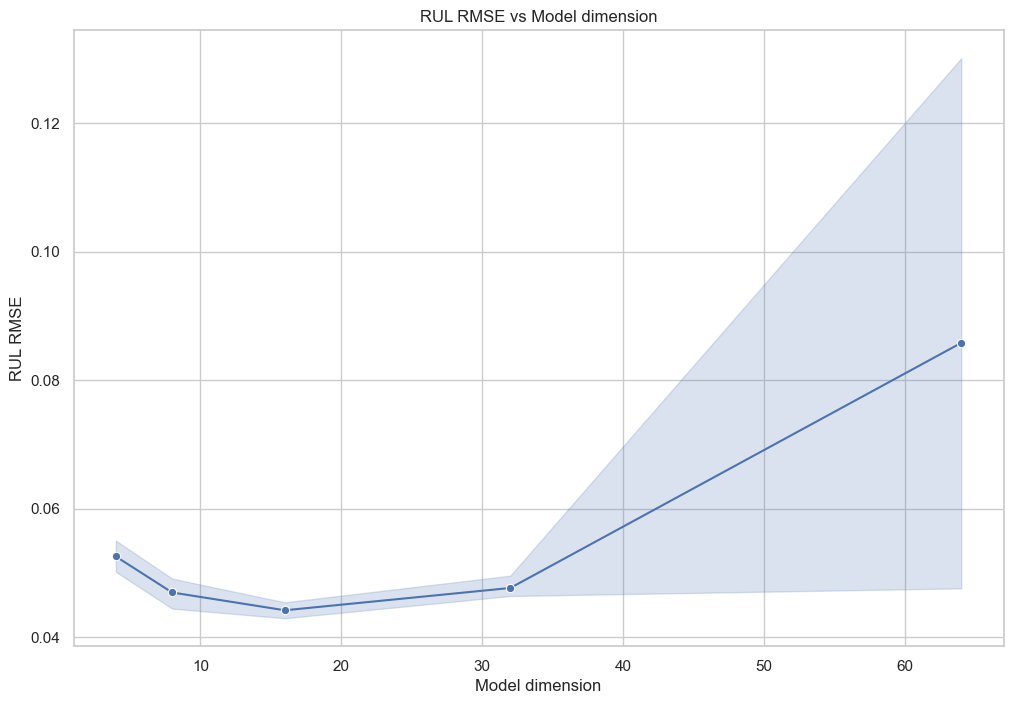

In [59]:
plt_path = 'param_search_res/group_res_new/nasa_m.csv'

xname = 'model_dim'
xlabel = 'Model dimension'
yname = 'rul_rmse_mean'
ylabel = 'RUL RMSE'
plt_title = f'{ylabel} vs {xlabel}'

df = pd.read_csv(plt_path)
# 按超参数分组，取最小值
# idx = df.groupby(xname)[yname].idxmin()
# df = df.loc[idx]

# df = df.groupby(xname).agg(
#     rul_rmse_mean=('rul_rmse_mean', 'mean'),
#     rul_rmse_std=('rul_rmse_std', 'mean')
# ).reset_index()
display(df.sort_values('rul_rmse_mean'))

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.lineplot(x=xname, y=yname, data=df, marker='o', errorbar=('ci', 90))
# plt.errorbar(df[xname], df[yname], yerr=df['rul_rmse_std'], fmt='-o', ecolor='gray', capsize=3, color='b')
plt.title(plt_title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
# plt.ylim(0.035, 0.06)
plt.show()

In [50]:
path = 'param_search_res/all_res_new/nasa_lr_bs.csv'
# path = result_path
df = pd.read_csv(path)
group_cols = ['lr', 'bs']
# group_cols = ['alpha']
# group_cols = ['num_heads', 'num_heads_s']
# group_cols = ['model']
df = df.groupby(group_cols)['val_rul_rmse'].agg(
    rul_rmse_mean='mean',
    rul_rmse_std='std'
).reset_index().sort_values('rul_rmse_mean')
df['rul_rmse'] = df.apply(lambda x: f"{x['rul_rmse_mean']:.4f} ± {x['rul_rmse_std']:.4f}", axis=1)
group_cols.append('rul_rmse')
df = df[group_cols]
df

,lr,bs,rul_rmse
40,0.0009,4,0.0423 ± 0.0115
25,0.0006,4,0.0437 ± 0.0125
26,0.0006,8,0.0446 ± 0.0193
41,0.0009,8,0.0463 ± 0.0119
48,0.0010,32,0.0466 ± 0.0103
35,0.0008,4,0.0468 ± 0.0125
31,0.0007,8,0.0472 ± 0.0186
18,0.0004,32,0.0473 ± 0.0151
0,0.0001,4,0.0474 ± 0.0175
14,0.0003,64,0.0475 ± 0.0152


# 画loss曲线

In [28]:
# 绘制图形
plt.figure(figsize=(10, 5))
start_epoch = 10
plt.plot(train_losses[start_epoch:], label='Training Loss', marker='o')
plt.plot(val_losses[start_epoch:], label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

,kdlh,rul_rmse,soh_rmse
248,7-4-3-1,0.0412 ± 0.0088,0.0336 ± 0.0258
135,5-1-2-8,0.0415 ± 0.0123,0.0381 ± 0.0341
184,5-4-3-1,0.0429 ± 0.0082,0.0346 ± 0.0244
206,7-1-4-4,0.0435 ± 0.0068,0.0195 ± 0.0085
142,5-1-4-4,0.0436 ± 0.0098,0.0238 ± 0.0135
...,...,...,...
239,7-3-4-8,0.1517 ± 0.1290,0.1432 ± 0.1979
173,5-3-4-2,0.1521 ± 0.1159,0.0760 ± 0.0758
31,2-2-4-8,0.1541 ± 0.1305,0.0548 ± 0.0430
95,3-2-4-8,0.1567 ± 0.1277,0.0675 ± 0.0532


In [30]:
model = get_model(model_config, device, lookback_len)
model.load_state_dict(torch.load(model_save_path, weights_only=True))

<All keys matched successfully>

# 画soh、rul曲线

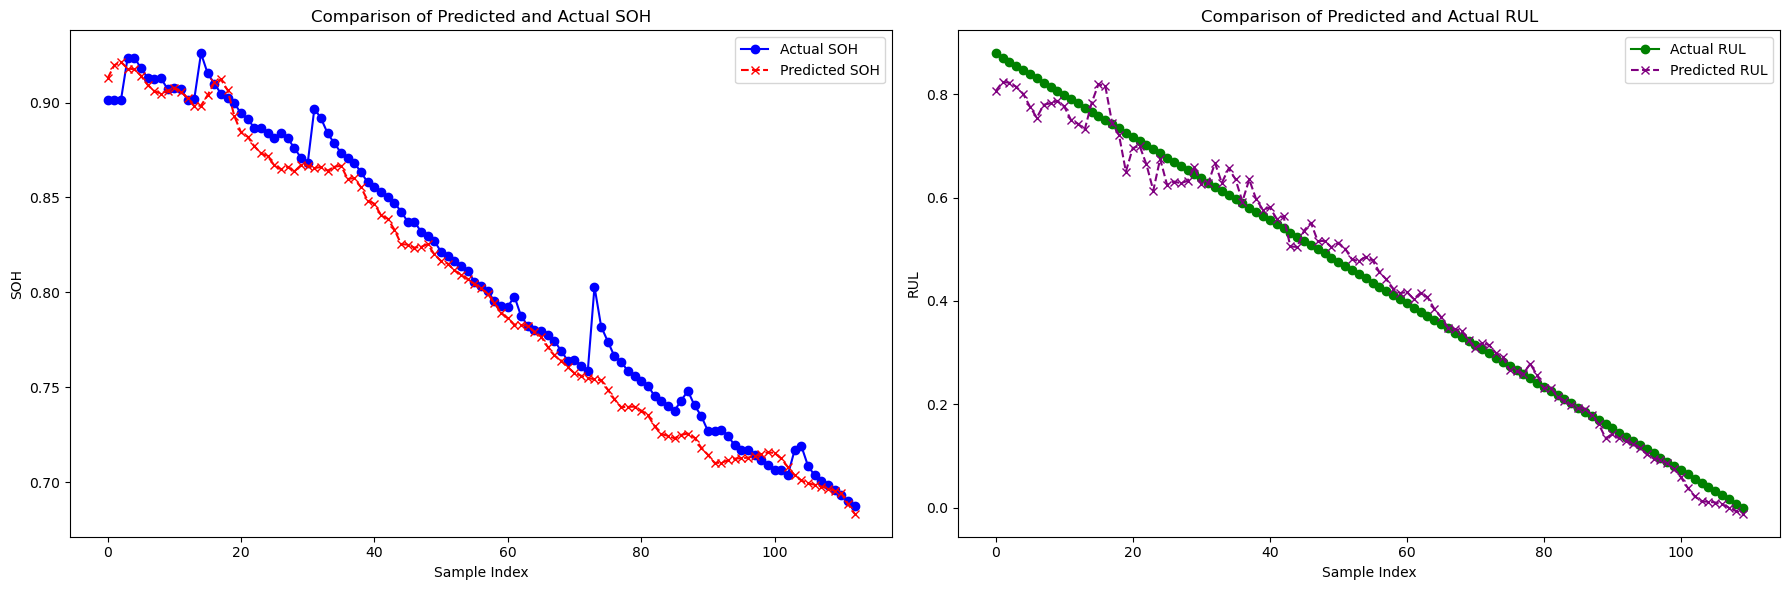

In [31]:
predictions_by_time = defaultdict(list)
true_by_time = defaultdict(list)
rul_preds = []
rul_true = []

model.eval()
with torch.no_grad():
    time_step = 0  # 初始化时间步
    for features, soh, rul in val_loader:
        soh_pred, rul_pred = model(features)
        
        # 转换为numpy数组以方便处理
        soh_pred = np.array(soh_pred)
        soh = np.array(soh)
        # 更新predictions_by_time
        for i in range(soh_pred.shape[0]):  # 遍历batch中的每个样本
            current_base_time = time_step + i
            for j in range(pred_len):  # 遍历每个样本的所有预测步
                predictions_by_time[current_base_time + j].append(soh_pred[i, j])
                true_by_time[current_base_time + j].append(soh[i, j])
        time_step += soh_pred.shape[0]  # 更新时间步
        
        rul_preds.extend(rul_pred.flatten().tolist())
        rul_true.extend(rul.tolist())

# 计算平均预测
average_predictions = {t: np.mean(vals) for t, vals in predictions_by_time.items()}
average_true = {t: np.mean(vals) for t, vals in true_by_time.items()}
soh_preds = list(average_predictions.values())
soh_true = list(average_true.values())

# 绘制SOH的预测与实际值对比图
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)  # 1行2列的第1个
plt.plot(soh_true, label='Actual SOH', color='blue', marker='o')
plt.plot(soh_preds, label='Predicted SOH', color='red', linestyle='--', marker='x')
plt.title('Comparison of Predicted and Actual SOH')
plt.xlabel('Sample Index')
plt.ylabel('SOH')
plt.legend()

# 绘制RUL的预测与实际值对比图
plt.subplot(1, 2, 2)  # 1行2列的第2个
plt.plot(rul_true, label='Actual RUL', color='green', marker='o')
plt.plot(rul_preds, label='Predicted RUL', color='purple', linestyle='--', marker='x')
plt.title('Comparison of Predicted and Actual RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()

plt.tight_layout()
plt.show()